## First Aproach

- Simular $n$ termoeléctricas ($t_i$ es el valor de generación máxima de la termoeléctrica $i$)
- El día 0 funcionan todas
- Si todas funcionan Oferta $\geq$ Demanda
- Simular tiempo de rotura (Weibull)
- Todas se pueden reparar a la vez
- Tiempo de reparación Lognormal
- Existen $m$ circuitos ($c_j$ es el valor de demanda del circuito $j$)
- $\delta_{ik}$ es un parámetro binario que expresa si la termoeléctrica $i$ está activa el día $k$
- $\alpha_{jk}$ es un parámetro binario que expresa si el circuito $j$ está activo el día $k$
- Existe capacidad de almacenamiento ($a_k$ es la capacidad de almacenamiento del sistema en el día $k$)
- $a_0 = 0$
- $a_k = \sum_{i=1}^{n} t_i\delta_{ik} + a_{k-1} - \sum_{j=1}^{m} c_j\alpha_{jk}, a_k \geq 0$
- No simularemos mantenimientos planificados, solo reparación por rotura
- No tendremos en cuenta fallas internas de los circuitos
- No habrán circuitos que dependan de termoeléctricas específicas
- La afectación a los circuitos se hará de manera proporcional (con una proporción que definiremos) y rotativa, cuando sea necesario
- Al final de la simulación calcularemos una afectación (fórmula por determinar)

In [18]:
from App.modules.weibull import Weibull
from App.modules.lognormal import LogNormal
from App.modules.event import Event
from App.modules.thermoelectric import ThermoElectric
from App.modules.agents import Agent
from App.modules.circuit import Circuit
from App.modules.roundrobin import RoundRobin
import random as rnd
import numpy as np
import copy
import matplotlib.pyplot as plt

In [19]:
def generate_thermoelectrics(days, thermoelectrics_amount):
    thermoelectrics = []
    for i in range(thermoelectrics_amount):
        w = Weibull(rnd.uniform(40, 70), rnd.uniform(1,3))
        l = LogNormal(rnd.uniform(2,2.5), rnd.uniform(0.2,0.4))
        o = rnd.randrange(0, 1000)
        t = ThermoElectric(o , w, l)
        t.planificate_events(days)
        thermoelectrics.append(t)

    return thermoelectrics

In [20]:
days = 365
thermoelectrics_amount = 20
stored_energy = 0
thermoelectrics = generate_thermoelectrics(days, thermoelectrics_amount)

In [21]:
for i in range(1):
    print(i)
    thermoelectrics[i].plot(0, 365)
    thermoelectrics[i].get_distributions_info()

0
350
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Weibull Distribution:
Scale: 49.41284008212971
Shape: 2.1523872015555714

LogNormal Distribution:
Mean: 2.259022931476323Des: 0.219202306567593


In [22]:
def get_next_general_event(thermoelectrics_list, days, current_day):
    next_event = days
    next_thermoelectric = None
    for t in thermoelectrics_list:
        tmp = t.get_next_future_event_day()
        if tmp < next_event and tmp >= current_day:
            next_event = tmp
            next_thermoelectric = t
    return (next_event, next_thermoelectric)

In [23]:
def simulate(thermoelectrics, days, agent=None, circuits=None, stored_energy=None):
    working_thermoelectrics = []
    working_thermoelectrics.append(np.ones(len(thermoelectrics)))
    deficit_per_day = []
    deficit_per_day.append(0)
    stored_energy_per_day = []
    stored_energy_per_day.append(0)
    total_demand = 0
    if circuits is not None:
        total_demand = sum([c.demand for c in circuits])
    circuits_history = []

    event_date, event_thermoelectric = get_next_general_event(thermoelectrics, days, 0)

    for current_day in range(0, days):
        
        if agent is not None:
            agent.Manage_Thermoelectrics(current_day)

        while(event_thermoelectric != None and np.floor(event_date) == current_day):
            event_thermoelectric.pop_next_future_event()
            event_date, event_thermoelectric = get_next_general_event(thermoelectrics, days, current_day)

        thermoelectrics_state = [t.is_working() for t in thermoelectrics]
        working_thermoelectrics.append(thermoelectrics_state)    

        if circuits is not None:
            if agent is not None:
                agent.Manage_Circuits(stored_energy, current_day)
            total_offer = sum([x.offer for x in thermoelectrics if x.is_working()]) + stored_energy_per_day[-1]
            deficit_today = total_demand - total_offer if total_demand > total_offer else 0
            deficit_per_day.append(deficit_today)
            stored_energy = total_offer - deficit_today if total_offer - deficit_today > 0 else 0
            stored_energy_per_day.append(stored_energy)

    if circuits is not None:
        circuits_history.append([c.deficit_history for c in circuits])
    
    return working_thermoelectrics, deficit_per_day, stored_energy_per_day, circuits_history

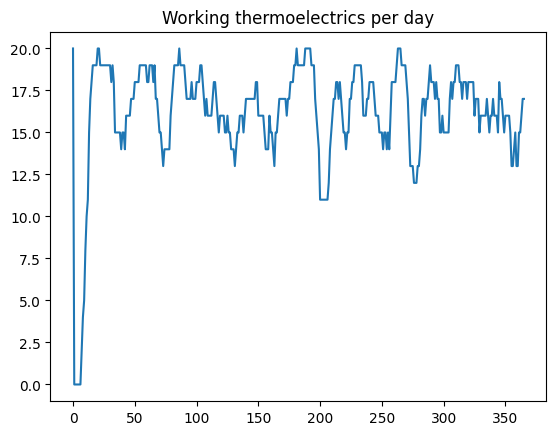

In [24]:
tmp = copy.deepcopy(thermoelectrics)
working_thermoelectrics, _, _, _ = simulate(tmp, days)
working_thermoelectrics = [sum(x) for x in working_thermoelectrics]


plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
plt.xlabel = 'Days'
plt.ylabel = 'Working thermoelectrics'
plt.show()

# Agent with thermoelectric mantainance strategy

In [25]:
def average_worktime(planification, days, amount):
    
    total_sum = 0
    total_intervals = 0

    for i in range(amount):
        sum = 0
        for j in range(days):
            if planification[j][i]:
                sum += 1
            elif sum != 0:
                total_sum += sum
                total_intervals += 1
                sum = 0
        if sum != 0:
            total_sum += sum
            total_intervals += 1
            sum = 0 
    return total_sum, total_intervals


In [26]:
def k_simulation(days, thermoelectrics_amount, k):
    
    sum = 0
    intervals = 0
    
    for i in range(k):
        thermoelectrics = generate_thermoelectrics(days, thermoelectrics_amount)
        thermoelectrics_state, _, _, _ = simulate(thermoelectrics, days)
        partial_sum, partial_intervals = average_worktime(thermoelectrics_state, days, thermoelectrics_amount)
        sum += partial_sum
        intervals += partial_intervals

    return sum/intervals if intervals != 0 else 0

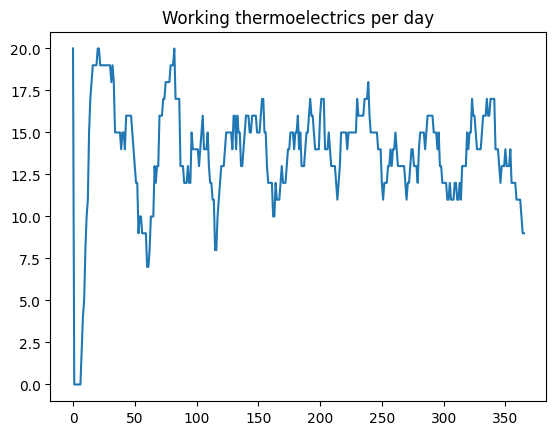

In [27]:
tmp = copy.deepcopy(thermoelectrics)

average = k_simulation(days, 20, 10)

def give_mantainance_heuristic(current_day):
    for thermoelectric in tmp:
        if not thermoelectric.is_working():
            continue
        last_repair = thermoelectric.get_last_repair_day()
        if current_day - last_repair >= average:
            thermoelectric.repair_and_replanificate(current_day, days, LogNormal(rnd.uniform(1.5,2), rnd.uniform(0.2,0.4)))

def empty_func(current_day):
    pass

working_thermoelectrics, _, _, _ = simulate(tmp, days, Agent(give_mantainance_heuristic, empty_func))
working_thermoelectrics = [sum(x) for x in working_thermoelectrics]

plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
plt.xlabel = 'Days'
plt.ylabel = 'Working thermoelectrics'
plt.show()

# Agent with circuits planification strategy

In [28]:
def generate_circuits(circuits_amount, days):
    circuits = []
    for i in range(circuits_amount):
        demand = rnd.lognormvariate(rnd.uniform(0,7), rnd.uniform(0.2,0.4))
        c = Circuit(i, demand, days)
        circuits.append(c)

    return circuits

#Initialize circuits
circuits_amount = 115
circuits = generate_circuits(circuits_amount, days)


In [29]:
def get_deficit_and_stored_energy(circuits, thermoelectrics, stored_energy):
    total_demand = sum([x.demand for x in circuits])
    total_offer = sum([x.offer for x in thermoelectrics if x.is_working()]) + stored_energy
    return (total_demand - total_offer, 0) if total_demand > total_offer else (0, total_offer - total_demand)

In [30]:
get_deficit_and_stored_energy(circuits, thermoelectrics, 0)    

(6265.547681197293, 0)

In [31]:
rotation = RoundRobin()

def disconnect_circuit_heuristic(stored_energy, current_day):
    deficit, stored_energy = get_deficit_and_stored_energy(circuits, thermoelectrics, stored_energy)
    while deficit > 0:
        circuit = circuits[rotation.next() %len(circuits)]
        if deficit > 1/4*circuit.demand: circuit.disconnect(1/4, current_day)
        else: circuit.disconnect(deficit/circuit.demand, current_day)
        deficit -= (circuit.demand/4 if deficit > 1/4*circuit.demand else deficit) 

Disconnecting 16.207140330423208 from circuit 5 on day 0
Total deficit: 405.1785082605803
Today's deficit: 16.207140330423208
Days disconnected: 25
Disconnecting 1.7085724693096787 from circuit 6 on day 0
Total deficit: 42.714311732741976
Today's deficit: 1.7085724693096787
Days disconnected: 25
Disconnecting 48.127358268701265 from circuit 7 on day 0
Total deficit: 1203.183956717532
Today's deficit: 48.127358268701265
Days disconnected: 25
Disconnecting 2.449280166794212 from circuit 8 on day 0
Total deficit: 61.23200416985527
Today's deficit: 2.449280166794212
Days disconnected: 25
Disconnecting 134.865294358215 from circuit 9 on day 0
Total deficit: 3349.6266689763047
Today's deficit: 134.865294358215
Days disconnected: 25
Disconnecting 16.864054489781896 from circuit 10 on day 0
Total deficit: 421.6013622445474
Today's deficit: 16.864054489781896
Days disconnected: 25
Disconnecting 136.97293498065915 from circuit 11 on day 0
Total deficit: 3424.3233745164807
Today's deficit: 136.97

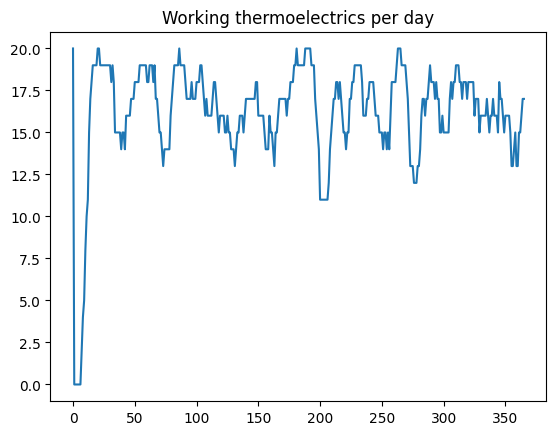

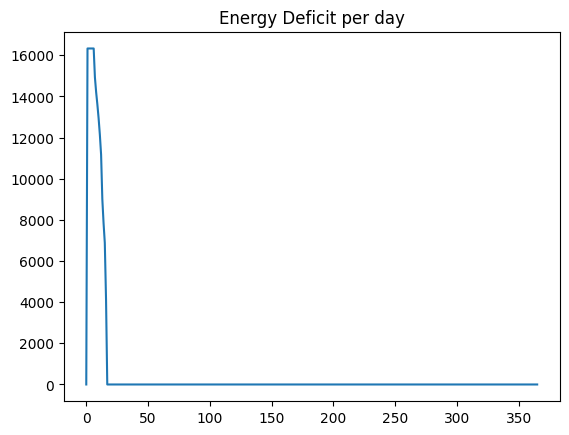

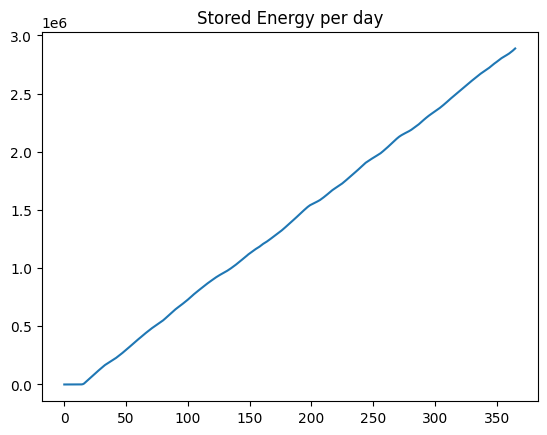

In [33]:
tmp_thermoelectrics = copy.deepcopy(thermoelectrics)
tmp_circuits = copy.deepcopy(circuits)


working_thermoelectrics, deficit_per_day, stored_energy_per_day, circuits_history = simulate(tmp_thermoelectrics, days, Agent(give_mantainance_heuristic, disconnect_circuit_heuristic), tmp_circuits, stored_energy)
working_thermoelectrics = [sum(x) for x in working_thermoelectrics]
print(circuits_history)
# days_disconnected_by_circuit = [len([x for x in y if x > 0]) for y in circuits_history]
# total_deficit_by_circuit = [sum(y) for y in circuits_history]

plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
plt.xlabel = 'Days'
plt.ylabel = 'Working thermoelectrics'
plt.show()

plt.plot(deficit_per_day)
plt.title('Energy Deficit per day')
plt.xlabel = 'Days'
plt.ylabel = 'Deficit'
plt.show()

plt.plot(stored_energy_per_day)
plt.title('Stored Energy per day')
plt.xlabel = 'Days'
plt.ylabel = 'Stored Energy'
plt.show()

In [ ]:
# Crear una lista de índices para el eje x
x = list(range(len(days_disconnected_by_circuit)))

plt.bar(x, days_disconnected_by_circuit)
plt.xlabel('Índice del Circuito')
plt.ylabel('Días Desconectados')
plt.title('Días Desconectados por Circuito')
plt.show()

NameError: name 'days_disconnected_by_circuit' is not defined